# Attack IP Classification Model

Use the sample feature data produced from `exploration.ipynb` to feed this prediction model. 

In [72]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import seaborn as sns
import imblearn
import random
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier


In [2]:
df = pd.read_csv('sample-features-ip2.csv')


In [3]:
cols = ['IP Address', 'Is Attack IP', 'Login Successful',
        'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
        'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
        'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
        'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'bot', 'desktop',
        'mobile', 'tablet']
df_features = df[cols]
df_features['Is Attack IP'] = df_features['Is Attack IP'].astype(int)
df_features = df_features.fillna(0)


/var/folders/dc/xfskm7hx35db80zpm6534xzr0000gn/T/ipykernel_20113/2790961587.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['Is Attack IP'] = df_features['Is Attack IP'].astype(int)


In [4]:
df_features[df_features.isna().any(axis=1)]


,IP Address,Is Attack IP,Login Successful,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,bot,desktop,mobile,tablet


In [5]:
df_features['Is Attack IP'].value_counts()


0    595766
1     17390
Name: Is Attack IP, dtype: int64

In [6]:
from imblearn.under_sampling import RandomUnderSampler
X = df_features.iloc[:, 2:].to_numpy()
y = df_features['Is Attack IP']

# from imblearn.over_sampling import SVMSMOTE
smote = imblearn.over_sampling.SMOTE(sampling_strategy=0.3)

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X, y)

print('Original dataset shape', y.value_counts())
print('Resample dataset shape', y_smote.value_counts())


Original dataset shape 0    595766
1     17390
Name: Is Attack IP, dtype: int64
Resample dataset shape 0    595766
1    178729
Name: Is Attack IP, dtype: int64


In [7]:
from sklearn.model_selection import StratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (tr_ind, val_ind) in enumerate(kfold.split(x_smote, y_smote)):
    scaler = MinMaxScaler()
    X_train, X_val = x_smote[tr_ind], x_smote[val_ind]
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    y_train, y_val = y_smote[tr_ind], y_smote[val_ind]
    cls = LogisticRegression()
    cls.fit(X_train, y_train)
    val_pred1 = cls.predict(X_val)
    print('Accuracy score -', fold+1, ': ', accuracy_score(y_val, val_pred1))


Accuracy score - 1 :  0.7792948953834434
Accuracy score - 2 :  0.7792819837442463
Accuracy score - 3 :  0.7790818533366903
Accuracy score - 4 :  0.7791851464502676
Accuracy score - 5 :  0.7794111001362178


In [9]:
from sklearn.model_selection import StratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (tr_ind, val_ind) in enumerate(kfold.split(x_smote, y_smote)):
    scaler = MinMaxScaler()
    X_train, X_val = x_smote[tr_ind], x_smote[val_ind]
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    y_train, y_val = y_smote[tr_ind], y_smote[val_ind]
    cls = DecisionTreeClassifier(max_depth=8)
    cls.fit(X_train, y_train)
    val_pred1 = cls.predict(X_val)
    print('Accuracy score -', fold+1, ': ', accuracy_score(y_val, val_pred1))


Accuracy score - 1 :  0.8487272351661406
Accuracy score - 2 :  0.8559835763949413
Accuracy score - 3 :  0.8448924783245857
Accuracy score - 4 :  0.8475329085404038
Accuracy score - 5 :  0.8462869353578784


In [10]:
# split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    x_smote, y_smote, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=43)  # 0.8 * 0.25 = 0.2 val data

# initialize the models
bagging_clf = BaggingClassifier()
random_forest_clf = RandomForestClassifier()
decision_tree_clf = DecisionTreeClassifier()
knn_clf = KNeighborsClassifier()
gbdt_clf = GradientBoostingClassifier()
nb_clf = GaussianNB()

# train the models
bagging_clf.fit(X_train, y_train)
print('bag done')
random_forest_clf.fit(X_train, y_train)
print('rf done')
decision_tree_clf.fit(X_train, y_train)
print('dt done')
knn_clf.fit(X_train, y_train)
print('knn done')
gbdt_clf.fit(X_train, y_train)
print('gb done')
nb_clf.fit(X_train, y_train)
print('nb done')

# predict using the trained models
bagging_preds = bagging_clf.predict(X_test)
random_forest_preds = random_forest_clf.predict(X_test)
decision_tree_preds = decision_tree_clf.predict(X_test)
knn_preds = knn_clf.predict(X_test)
gbdt_preds = gbdt_clf.predict(X_test)
nb_preds = nb_clf.predict(X_test)

# calculate f1 scores
bagging_f1 = f1_score(y_test, bagging_preds)
random_forest_f1 = f1_score(y_test, random_forest_preds)
decision_tree_f1 = f1_score(y_test, decision_tree_preds)
knn_f1 = f1_score(y_test, knn_preds)
gbdt_f1 = f1_score(y_test, gbdt_preds)
nb_f1 = f1_score(y_test, nb_preds)

# calculate accuracy
print("Bagging accuracy: ", round(accuracy_score(y_test, bagging_preds), 4))
print("Random Forest accuracy: ", round(
    accuracy_score(y_test, random_forest_preds), 4))
print("Decision Tree accuracy: ", round(
    accuracy_score(y_test, decision_tree_preds), 4))
print("KNN accuracy: ", round(accuracy_score(y_test, knn_preds), 4))
print("GBDT accuracy: ", round(accuracy_score(y_test, gbdt_preds), 4))
print("Naive Bayes accuracy: ", round(
    accuracy_score(y_test, nb_preds), 4), "\n")

# print f1 scores
print("Bagging f1 score: ", round(bagging_f1, 4))
print("Random Forest f1 score: ", round(random_forest_f1, 4))
print("Decision Tree f1 score: ", round(decision_tree_f1, 4))
print("KNN f1 score: ", round(knn_f1, 4))
print("GBDT f1 score: ", round(gbdt_f1, 4))
print("Naive Bayes f1 score: ", round(nb_f1, 4), '\n')

# We care more about false positives
print("Bagging recall: ", round(recall_score(y_test, bagging_preds), 5))
print("Random Forest recall: ", round(
    recall_score(y_test, random_forest_preds), 5))
print("Decision Tree recall: ", round(
    recall_score(y_test, decision_tree_preds), 5))
print("KNN recall: ", round(recall_score(y_test, knn_preds), 5))
print("GBDT recall: ", round(recall_score(y_test, gbdt_preds), 5))
print("Naive Bayes recall: ", round(recall_score(y_test, nb_preds), 5))


bag done
rf done
dt done
knn done
gb done
nb done
Bagging accuracy:  0.9405
Random Forest accuracy:  0.9434
Decision Tree accuracy:  0.9229
KNN accuracy:  0.8406
GBDT accuracy:  0.9091
Naive Bayes accuracy:  0.2293 

Bagging f1 score:  0.8553
Random Forest f1 score:  0.863
Decision Tree f1 score:  0.8198
KNN f1 score:  0.7003
GBDT f1 score:  0.7593
Naive Bayes f1 score:  0.3721 

Bagging recall:  0.7641
Random Forest recall:  0.7745
Decision Tree recall:  0.76091
KNN recall:  0.80841
GBDT recall:  0.62238
Naive Bayes recall:  0.9912


In [17]:
pred_proba = bagging_clf.predict_proba(X_test)


In [71]:
sns.displot(pred_proba[:, 1])


In [58]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True, False],
    'max_features': [1.0],
    'max_samples': [1.0],
    'n_estimators': [5, 10, 15, 20]
}

bagging_clf_val = BaggingClassifier()

search = GridSearchCV(bagging_clf_val, param_grid, cv=5, scoring='accuracy')
search.fit(X_val, y_val)


GridSearchCV(cv=5, estimator=BaggingClassifier(),
             param_grid={'base_estimator': [None], 'bootstrap': [True],
                         'bootstrap_features': [False], 'max_features': [1.0],
                         'max_samples': [1.0],
                         'n_estimators': [5, 10, 15, 20]},
             scoring='accuracy')

In [59]:
res = search.cv_results_
res['mean_test_score']


array([0.92095494, 0.92543528, 0.92827583, 0.92859863])

In [62]:
from sklearn.model_selection import StratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

params = search.best_params_
print(params)

scores = []
for fold, (tr_ind, val_ind) in enumerate(kfold.split(x_smote, y_smote)):
    scaler = MinMaxScaler()
    xval_train, xval_test = x_smote[tr_ind], x_smote[val_ind]
    xval_train = scaler.fit_transform(xval_train)
    xval_test = scaler.transform(xval_test)
    yval_train, yval_val = y_smote[tr_ind], y_smote[val_ind]
    cls = BaggingClassifier(**params)
    cls.fit(xval_train, yval_train)
    val_pred1 = cls.predict(xval_test)
    score = accuracy_score(yval_val, val_pred1)
    scores.append(score)
    print('Accuracy score -', fold+1, ': ', score)
print(np.mean(scores))
print(np.var(scores)) 


{'base_estimator': None, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 20}
Accuracy score - 1 :  0.9435635894125242
Accuracy score - 2 :  0.9428663653970304
Accuracy score - 3 :  0.9439767591994835
Accuracy score - 4 :  0.9447385409941897
Accuracy score - 5 :  0.9438863783085862
Accuracy score - 6 :  0.9440664179008121
Accuracy score - 7 :  0.9438985655076244
Accuracy score - 8 :  0.944905679866751
Accuracy score - 9 :  0.943265891102532
Accuracy score - 10 :  0.9444795930225052
0.9439647780712039
3.6259502503042424e-07


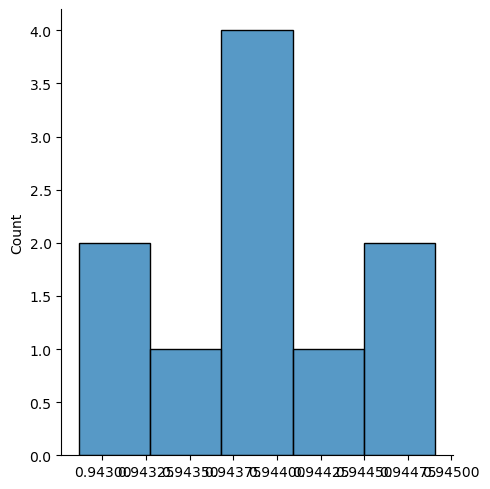

In [74]:
sns.displot(scores)
plt.show()

In [77]:
confusion_matrix(yval_val, val_pred1)

array([[59170,   406],
       [ 3894, 13979]])

In [14]:
df_features.to_csv('attack_preds.csv', index=False)


ValueError: Wrong number of items passed 2, placement implies 1